In [ ]:
# Dataset: https://www.kaggle.com/jessicali9530/celeba-dataset

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, DirectoryIterator
from tensorflow.keras.optimizers import SGD

from tensorflow import keras
import numpy as np
from tqdm import tqdm
import cv2

In [2]:
import sys
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

print(sys.version)
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13799642563782953318
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6932588160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3946616636438442750
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5"
]
3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
2.4.1


# Implement and Customize Darknet53

In [3]:
class ConvBlock(keras.layers.Layer):
    def __init__(self, num_filters, kernel_size, strides=1, data_format='channels_last'):
        
        super(ConvBlock, self).__init__()
        self.kernel_size = kernel_size
        self.strides = strides
        self.data_format = data_format
        
        self.conv = layers.Conv2D(num_filters,
                                            kernel_size,
                                            strides,
                                            padding = ('same' if strides == 1 else 'valid'), 
                                            data_format=data_format, 
                                            use_bias=False,
                                            kernel_initializer='random_normal')
        self.batchnorm = layers.BatchNormalization(
                            axis = -1 if data_format == "channels_last" else 1,
                            momentum=0.99,
                            #epsilon=0.01)
                            epsilon=1e-05)
        self.leaky_relu = layers.LeakyReLU(alpha=0.1)

    def call(self, x, training=False):
        
        if self.strides > 1:
            x = self._fixed_padding(x, self.kernel_size)
            
        output = self.conv(x)
        output = self.batchnorm(output, training=training)
        output = self.leaky_relu(output)
        
        return output
    
    def _fixed_padding(self, inputs, kernel_size, mode='CONSTANT'):
        pad_total = kernel_size - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg

        if self.data_format == 'channels_first':
            padded_inputs = tf.pad(tensor=inputs, paddings=[[0, 0], [0, 0], [pad_beg, pad_end], [pad_beg, pad_end]], mode=mode)
        else:
            padded_inputs = tf.pad(tensor=inputs, paddings=[[0, 0], [pad_beg, pad_end], [pad_beg, pad_end], [0, 0]], mode=mode)

        return padded_inputs


class DarknetBlock(layers.Layer):
    def __init__(self, num_filters, data_format='channels_last'):
        
        super(DarknetBlock, self).__init__()

        self.conv1 = ConvBlock(num_filters, 1, data_format=data_format)
        self.conv2 = ConvBlock(num_filters*2, 3, data_format=data_format)
        self.add = layers.Add()
    
    def call(self, x, training=False):

        shortcut = x
        output = self.conv1(x,training=training)
        output = self.conv2(output,training=training)        
        output = self.add([output, shortcut])
            
        return output

## Add a Custom Layer

In [4]:
def define_darknet53(input_shape=(128, 128, 3)):
    inputs = tf.keras.Input(input_shape, name='img')

    #conv filter=32 size=3x3
    output = ConvBlock(32,3,strides=1)(inputs)

    #conv filter=64 size=3x3
    output = ConvBlock(64,3,strides=2)(output)

    #darknet conv
    output = DarknetBlock(32)(output)

    #darknet block x2
    output = ConvBlock(128,3,strides=2)(output)
    for _ in range(2):
        output = DarknetBlock(64)(output)

    #darknet block x8
    output = ConvBlock(256,3,strides=2)(output)
    for _ in range(8):
        output = DarknetBlock(128)(output)
    output_8_128 = Flatten()(output)

    #darknet block x8
    output = ConvBlock(512,3,strides=2)(output)
    for _ in range(8):
        output = DarknetBlock(256)(output)
    output_8_512 = Flatten()(output)

    #darknet block x4
    output = ConvBlock(1024,3,strides=2)(output)  
    for _ in range(4):
        output = DarknetBlock(512)(output)

    #dense
    output = layers.GlobalAvgPool2D()(output)
    output = layers.Reshape((1,1,1024))(output)
    output = layers.Conv2D(1000,1)(output)

    output = Flatten()(output)
    # Customized Layer: [lefteye_x	lefteye_y	righteye_x	righteye_y	nose_x	nose_y	leftmouth_x	leftmouth_y	rightmouth_x	rightmouth_y]
    concatenate = Concatenate(axis=1)([output, output_8_128, output_8_512])
    output = Dense(10, name = 'output')(concatenate)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [5]:
model = define_darknet53(input_shape=(218,178,3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 218, 178, 3) 0                                            
__________________________________________________________________________________________________
conv_block (ConvBlock)          (None, 218, 178, 32) 992         img[0][0]                        
__________________________________________________________________________________________________
conv_block_1 (ConvBlock)        (None, 109, 89, 64)  18688       conv_block[0][0]                 
__________________________________________________________________________________________________
darknet_block (DarknetBlock)    (None, 109, 89, 64)  20864       conv_block_1[0][0]               
______________________________________________________________________________________________

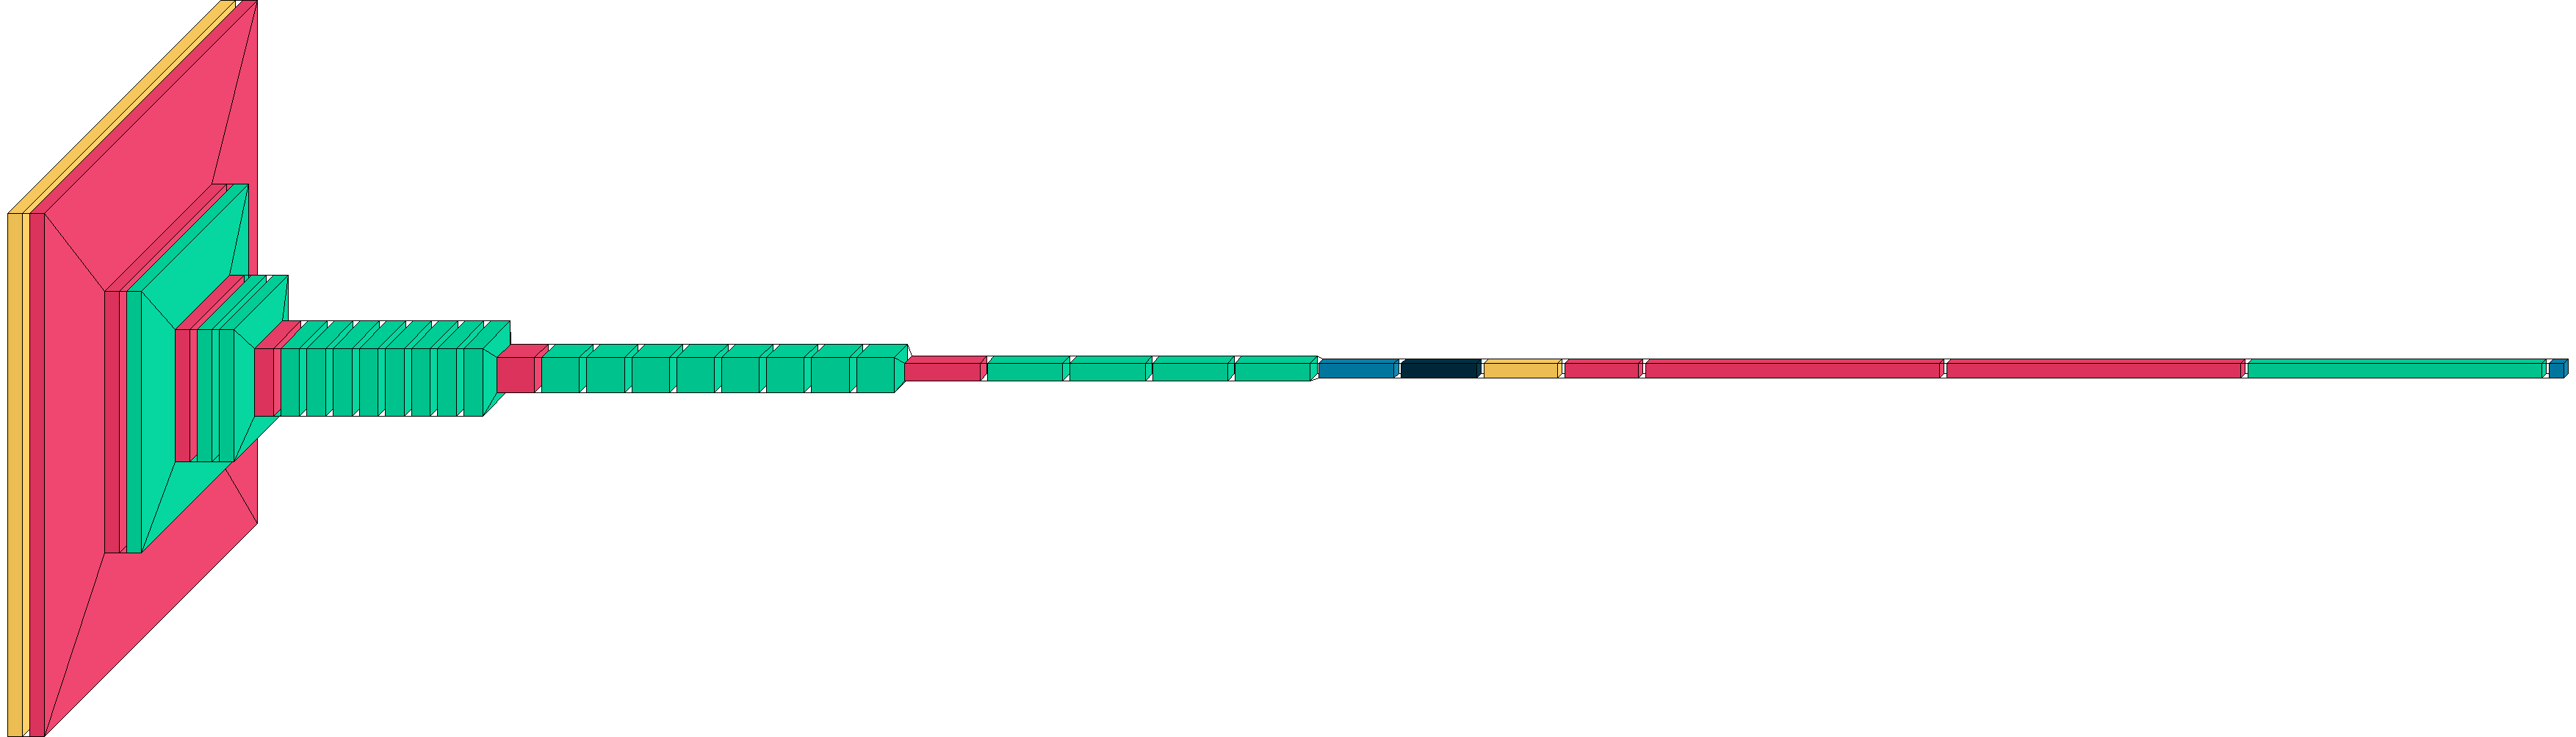

In [6]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model)

## Load Image Dataset

In [7]:
import pandas as pd
dataframe = pd.read_csv('dataset/list_landmarks_align_celeba.csv')
dataframe

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150
...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,69,111,108,111,89,140,73,151,104,153
202595,202596.jpg,67,112,110,112,85,141,66,150,110,150
202596,202597.jpg,69,111,107,111,92,137,68,151,109,153
202597,202598.jpg,69,111,108,111,90,137,71,153,106,151


## Take a sample

In [8]:
sample = dataframe.sample()
sample

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
197410,197411.jpg,67,113,110,112,89,130,71,150,105,150


In [9]:
import cv2

def landmark_img(img, landmarks):
    '''Draw red dots on pictures'''
    circle_size = 3
    color=(0, 0, 255)
    img = cv2.circle(img, (landmarks['lefteye_x'], landmarks['lefteye_y']), circle_size, color=color)
    img = cv2.circle(img, (landmarks['righteye_x'], landmarks['righteye_y']), circle_size, color=color)
    img = cv2.circle(img, (landmarks['nose_x'], landmarks['nose_y']), circle_size, color=color)
    img = cv2.circle(img, (landmarks['leftmouth_x'], landmarks['leftmouth_y']), circle_size, color=color)
    img = cv2.circle(img, (landmarks['rightmouth_x'], landmarks['rightmouth_y']), circle_size, color=color)

    return img

./dataset/img_align_celeba/img_align_celeba/197411.jpg


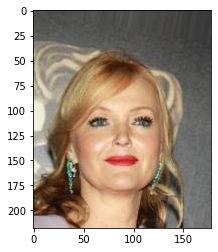

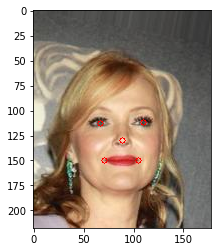

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2

# get the filepath in dataframe
path = f'./dataset/img_align_celeba/img_align_celeba/{sample.iloc[0].image_id}'
print(path)
img = cv2.imread(path, cv2.IMREAD_COLOR)

# opencv load picture in order BGR, convert it to RGB
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# add landmarks
img = landmark_img(img, sample.iloc[0])

# opencv load picture in order BGR, convert it to RGB
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


## Dataset is too huge, make a custom DataGenerator

In [11]:
from tensorflow.keras.utils import Sequence
import numpy as np
class DataGenerator(Sequence):
    '''
    Customized data generator. It find path in given dataframe and read picture data from disk
    '''
    def __init__(self, dataframe, batch_size=32, dim=(218,178,3), n_outputs=10, epoch_size=10000, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.dataframe = dataframe
        self.labels = np.array(self.dataframe[['lefteye_x',	'lefteye_y', 'righteye_x', 'righteye_y', 'nose_x', 'nose_y',	 'leftmouth_x', 'leftmouth_y', 'rightmouth_x','rightmouth_y']])
        self.n_outputs = n_outputs
        self.shuffle = shuffle
        self.epoch_size = epoch_size
        self.on_epoch_end()
        self.len = min(len(self.dataframe), epoch_size) // self.batch_size
    def __len__(self):
        return self.len

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.dataframe))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size, self.n_outputs), dtype=float)
        for i, ID in enumerate(indexes):
            path = f'./dataset/img_align_celeba/img_align_celeba/{self.dataframe.iloc[ID].image_id}'
            X[i,] = cv2.imread(path, cv2.IMREAD_COLOR)
            y[i,] = self.labels[ID]
        return X/255, y

## Split Dataset and Train

In [12]:
from sklearn.model_selection import train_test_split

# Split data
train_set, test_set = train_test_split(dataframe, test_size=0.3)

# Dataset is too huge, only use 5000 pictures in each epoch.
train_generator = DataGenerator(train_set, epoch_size=5000)

# Dataset is too huge, only use 5000 pictures in each epoch to validate.
test_generator = DataGenerator(test_set, epoch_size=1000)

In [13]:
# Training...
history=model.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5
156/156 [==============================] - 41s 222ms/step - loss: 27177.5155 - val_loss: 2036.5914
Epoch 2/5
156/156 [==============================] - 33s 214ms/step - loss: 204.2878 - val_loss: 123.3290
Epoch 3/5
156/156 [==============================] - 34s 216ms/step - loss: 25.7455 - val_loss: 11.4693
Epoch 4/5
156/156 [==============================] - 34s 215ms/step - loss: 37.5592 - val_loss: 109.1988
Epoch 5/5
156/156 [==============================] - 34s 216ms/step - loss: 23.6088 - val_loss: 10.3700


## Validation

In [14]:
# Randomly select 5 pictures to visualize the validation

samples = test_set.sample(5)
samples

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
26759,026760.jpg,68,111,108,112,85,134,68,151,110,152
40276,040277.jpg,69,111,107,111,88,131,72,153,105,152
51424,051425.jpg,67,111,109,113,84,147,68,150,111,152
100818,100819.jpg,67,110,109,114,82,139,65,148,115,154
86444,086445.jpg,68,112,109,111,87,130,69,151,107,152


In [28]:
img_data = np.empty((5, *(218,178,3)), dtype=np.float32)

for i, line in enumerate(samples.iloc):
    path = f'./dataset/img_align_celeba/img_align_celeba/{line.image_id}'
    img_data[i,]=cv2.imread(path, cv2.IMREAD_COLOR)/255
    
pred_y = model.predict(img_data)
pred_y

array([[ 67.91542 , 109.52562 , 106.57796 , 109.43021 ,  82.58133 ,
        134.19911 ,  71.15257 , 149.41183 , 103.472786, 150.49101 ],
       [ 68.516945, 108.98159 , 105.39055 , 109.288925,  85.96318 ,
        133.12685 ,  71.215485, 149.79156 , 102.97942 , 150.7493  ],
       [ 69.66274 , 109.981125, 106.5284  , 110.53193 ,  81.782104,
        136.6843  ,  72.39504 , 150.5459  , 105.23702 , 152.20107 ],
       [ 68.76054 , 109.17006 , 105.44181 , 109.493065,  82.26735 ,
        133.52904 ,  72.32421 , 150.38454 , 102.46149 , 151.17337 ],
       [ 69.010284, 109.68125 , 106.15588 , 110.20018 ,  87.56483 ,
        131.90555 ,  72.47689 , 150.6397  , 102.79197 , 151.1133  ]],
      dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


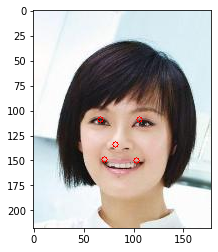

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


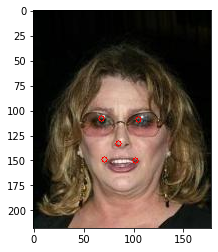

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


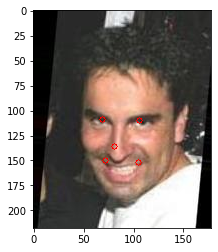

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


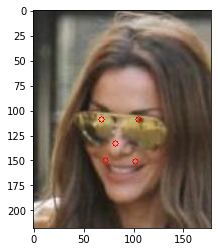

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


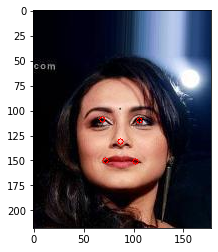

In [29]:
circle_size = 3
color=(0, 0, 255)

for i, img in enumerate(img_data):
    landmarks = pred_y[i]

    for landmark_index in range(0, 10, 2):
        img = cv2.circle(img, (int(landmarks[landmark_index]), int(landmarks[landmark_index+1])), circle_size, color=color)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = plt.imshow(img)
    plt.show()
